# HW04: RDD and Diff-in-Diff (due 24th October 23:59)

**You will have to solve only one of the two parts (either the RDD or the DiD) to get full credit for this homework.**

In this homework you will investigate the causal effect in two different settings, applying different **identification strategies**, You will also reflect and investigate the identification assumptions that allow for a causal interpretation. 

## Regression Discontinuity Design

In this first part you will use data on mayors from municipalities in Brazil to invesitgate th effect of electoral accountability on corruption. The goal is to estimate the effect of being eligible for reelection (having reelection incentives) on misappropriation of resources exploiting random audits on municipalities before the elections. In Brazil there is a two mandate limit for mayors, implying that only mayors in the first mandate can be reelected. The reference paper is [Ferraz and Finan (2011)](https://www.aeaweb.org/articles?id=10.1257/aer.101.4.1274).

In [3]:
#!pip install rdrobust

In [1]:
from rdrobust import rdrobust, rdbwselect, rdplot
import pandas as pd 
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings = lambda *a, **kw: None


In [2]:
df = pd.read_stata('data/HW04_data_rdd.dta')

C:\Users\ronan\AppData\Local\Temp\ipykernel_10092\2619628620.py:1: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.


In [3]:
df_labels = pd.read_stata('data/HW04_data_rdd.dta', iterator=True).variable_labels()
df_labels

C:\Users\ronan\AppData\Local\Temp\ipykernel_10092\1581965592.py:1: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.


{'uf': 'state',
 'nsorteio': 'Número do sorteio',
 'totrecursos': 'Total de recurso fiscalizado no municipio',
 'tot_os': 'Total de OS fiscalizadas no municipio',
 'pop': 'População no ano de 2000',
 'purb': 'Proporção da população urbana no ano de 2000',
 'p_secundario': 'Proporção da população com 18 anos ou mais com secundario completo',
 'cod_ibge6': 'cod_ibge6',
 'pib_capita_02': 'PIB per capita deflacionado em reais de 2001',
 'op_01_04': 'Dummy se o munic teve orçamento participativo no periodo',
 'reeleito': 'Dummy de reeleição',
 'ENEP2000': '2000 ENEP',
 'ENLP2000': '2000 ENLP',
 'pref_idade_tse': 'Idade do prefeito',
 'comarca': 'Sede de Comarca',
 'reeleito_2004': 'Dummy dos candidatos que se reelegeram na eleição de 2004',
 'p_cad_pref': 'Proporção de vereadores eleitos do mesmo partido do prefeito',
 'rec_transf_correntes': '(mean) rec_transf_correntes',
 'gini_ipea': '',
 'fiscalizacoes': 'Total ordens de serviço dada pela planilha CGU',
 'valor_fiscalizado': 'Total orde

In [4]:
pd.set_option("display.max_columns", None)
df = df[df['esample2']==1]
df.head()

,uf,nsorteio,totrecursos,tot_os,pop,purb,p_secundario,cod_ibge6,pib_capita_02,op_01_04,reeleito,ENEP2000,ENLP2000,pref_idade_tse,comarca,reeleito_2004,p_cad_pref,rec_transf_correntes,gini_ipea,fiscalizacoes,valor_fiscalizado,incumbent,vereador9600,pmismanagement,elected1,first,lpib02,lpop,pref_masc,pref_escola,media2,vereador_eleit,mun_novo,exp_prefeito,samepartygov98,lrec_trans,lfunc_ativ,lrec_fisc,ncorrupt,valor_corrupt,pcorrupt,dcorrupt,esample2,wm,winning_margin,party
0,RO,5,6913597.38,47.0,18207,0.815401,0.248250,566128.0,3548.000977,0,0,6.900685,5.400000,60.0,1,0,0.111111,8.688842e+06,0.600,47,6913597.38,1.0,0.0,0.928571,0.0,1.0,-1.036201,9.809562,1.0,4.0,1.0,0.000675,0.0,0.0,0.0,15.977551,6.167517,15.749001,3.0,672785.125,0.097313,1.0,1.0,0.030935,-0.030935,16
1,RO,7,7135210.78,62.0,10459,0.198203,0.110925,566130.0,4203.421875,0,1,5.173238,4.263158,34.0,0,0,0.333333,4.871684e+06,0.564,62,7135210.78,0.0,NaN,1.111111,0.0,0.0,-0.866686,9.255219,1.0,6.0,1.0,0.001625,1.0,0.0,0.0,15.398951,5.641907,15.780552,0.0,0.000,0.000000,0.0,1.0,0.172863,0.172863,3
2,RO,2,26821074.06,140.0,40884,0.649178,0.254702,566138.0,3904.267334,0,1,7.803850,7.258064,42.0,1,0,0.133333,1.747097e+07,0.600,140,26821074.06,0.0,NaN,0.806452,0.0,0.0,-0.940515,10.618494,1.0,6.0,1.0,0.000562,0.0,0.0,1.0,16.676052,6.872128,17.104698,1.0,0.000,0.000000,1.0,1.0,0.310956,0.310956,18
3,RO,4,14710780.70,89.0,47382,0.726457,0.267212,566151.0,4081.257812,0,1,6.499936,5.761904,41.0,1,0,0.272727,2.088945e+07,0.575,89,14710780.70,0.0,NaN,0.191489,0.0,0.0,-0.896180,10.765998,1.0,5.0,1.0,0.000383,0.0,0.0,1.0,16.854755,6.979145,16.504091,0.0,0.000,0.000000,0.0,1.0,0.391912,0.391912,18
4,RO,3,4181534.83,NaN,23874,0.271257,0.134546,566155.0,2192.473633,1,1,5.946526,5.400000,47.0,0,0,0.222222,8.795000e+06,0.531,69,4181534.83,0.0,NaN,NaN,0.0,0.0,-1.517555,10.080545,1.0,3.0,1.0,0.000945,1.0,0.0,0.0,15.989694,6.118097,15.246189,0.0,0.000,0.000000,0.0,1.0,0.186155,0.186155,14


The main outcome of interest is *pcorrupt*, namely, the share of audited resources found that involve corruption (a measure of misappropriation). The explanatory variable is *first*, a dummy variable indicating whether the mayor is in his first mandate. The regression of interest is the following: 

$$pcorrupt_i = \beta_0 + \beta_1 first_i + \varepsilon_i$$

In [5]:
## run the regression above using robust standard errors
import statsmodels.formula.api as smf 
from statsmodels.iolib.summary2 import summary_col


ols1 = smf.ols(formula="pcorrupt ~ first", data=df).fit()
summary_col(ols1)

,pcorrupt
Intercept,0.0737
,(0.0071)
first,-0.0188
,(0.0094)
R-squared,0.0084
R-squared Adj.,0.0063


**What could be some sources of bias, namely, variables that act as confounder?**

**Answer:**
- reeleito: Reelection impacts direclty if it is the first year or not of a mayor. But it also indicates if the judge got reelected by corruption.
- reeleito_2004: For the same reason as reeleito.
- incumbent: Individuals who currently hold the office they are seeking to be re-elected to impacts if the number of first year in the office and potential corruption.

In [6]:
## run the regression above adding the variables that may act as a confounder
ols2 = smf.ols(formula="pcorrupt ~ first + reeleito + reeleito_2004 + incumbent", data=df).fit()

In [37]:
## display the results 
summary_col(ols2)

,pcorrupt
Intercept,0.0451
,(0.0041)
first,0.0166
,(0.0072)
reeleito,0.0285
,(0.0058)
reeleito_2004,-0.0252
,(0.0126)
incumbent,0.0066
,(0.0124)


**In your opinion, are there any additional sources of bias that threatens the causal interpretation of the results?**

Yes, there is definetly some unobserved sources of bias such as the size and budget of the municipality.

To make sure that this is not the case we will use a regression discontinuity design where the running variable is the margin by which the incumbent won or lost in the previous election. Namely, we compare municipalities where incumbents won or lost by a narrow margin. This comparison provides quasi-random assignment of first-term and second-term mayors across these competitive elections.

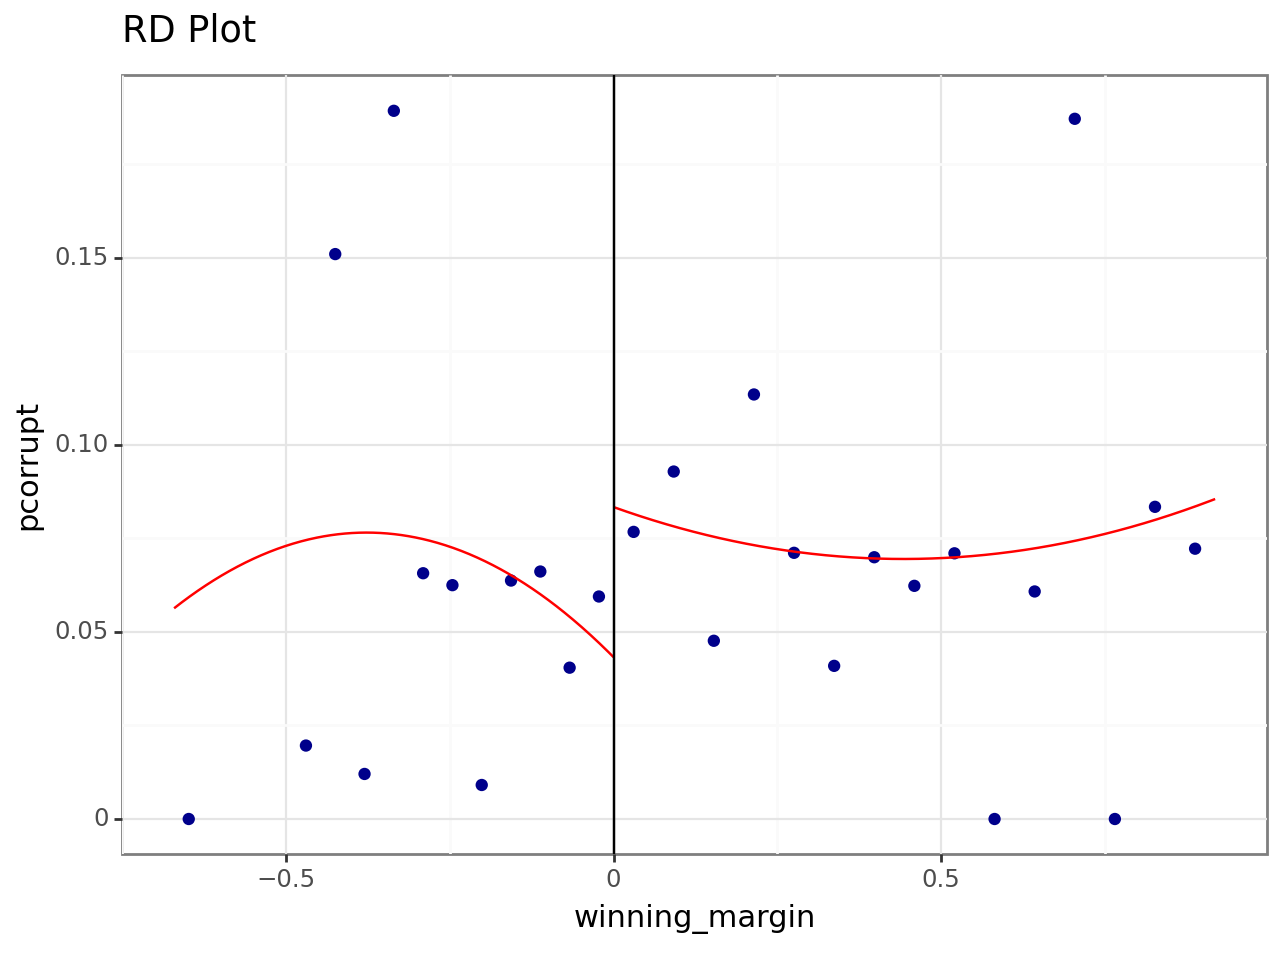


Call: rdplot
Number of Observations:                   328
Kernel:                               Uniform
Polynomial Order Est. (p):                  2

                                Left      Right
------------------------------------------------
Number of Observations           126        202
Number of Effective Obs          126        202
Bandwith poly. fit (h)         0.671      0.918
Number of bins scale               1          1
Bins Selected                     15         15
Average Bin Length             0.048      0.061
Median Bin Length              0.045      0.061
IMSE-optimal bins                5.0        3.0
Mimicking Variance bins         15.0       11.0

Relative to IMSE-optimal:
Implied scale                    3.0        5.0
WIMSE variance weight          0.036      0.008
WIMSE bias weight              0.964      0.992


In [38]:
## plot the RD plot using as running variable the variable winning_margin
## use a second order polynomial and 15 bins at each side

margin = df.dropna(subset=['winning_margin']).winning_margin
corruption = df.dropna(subset=['winning_margin']).pcorrupt
rdplot(y=corruption, x=margin, c=0, p=2, nbins=15, y_label='pcorrupt', x_label='winning_margin')

In [46]:
## run the RD regression using the same dependent and explanatory variable as before
## include 4th degree polynomial and the covariates that you included above
covs = df.dropna(subset=['winning_margin'])[["reeleito", 'reeleito_2004']]
print(rdrobust(y=corruption, x=margin, p=4, covs=covs))

Call: rdrobust
Number of Observations:                   328
Polynomial Order Est. (p):                  4
Polynomial Order Bias (q):                  5
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations           126        202
Number of Unique Obs.            126        201
Number of Effective Obs.          95        124
Bandwidth Estimation           0.206      0.206
Bandwidth Bias                 0.276      0.276
rho (h/b)                      0.745      0.745

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       0.021    0.041    0.507   6.124e-01     [-0.06, 0.102]
Robust                 -        -    0.697   4.861e-01    [-0.054, 0.113]



**Interpret the coefficient**

The confidence interval contains the 0 in it. So we can't make any assumption about the impact of the judge being in his first year and pcorrupt.

## Difference-in-Differences

In this part you will use data from Argentina to investigate the causal effect of police on crime. Following the paper by [Di Tella and Schargrodsky (2004)](https://www.aeaweb.org/articles?id=10.1257/000282804322970733), you will exploit the follow-up of a terrorist attack tto the Jewish center in Buenos Aires in July 1994, after which all Jewish institution received police protection. This event induced a geographical allocation of police forces orthogonal to a crime regression allowing to isolate the causal effect of having more police in a neighborhood on a proxy for crime (car thefts), through a difference-in-differences analysis. 

In [48]:
df = pd.read_stata('data/HW04_data_DiD.dta')
df_labels = pd.read_stata('data/HW04_data_DiD.dta', iterator=True).variable_labels()
df_labels

C:\Users\ronan\AppData\Local\Temp\ipykernel_10640\1792503655.py:1: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.


{'observ': 'block id',
 'barrio': 'neighborhood',
 'calle': 'street',
 'altura': 'street numbering',
 'institu1': 'dummy Jewish institution in the block',
 'institu3': 'dummy Jewish institution one block away',
 'distanci': 'block distance to closest institution',
 'edpub': 'dummy public building/embassy',
 'estserv': 'dummy gas station',
 'banco': 'dummy bank',
 'totrob': 'car theft',
 'mes': 'month',
 'inst3_1': '',
 'month5': '',
 'post': '',
 'inst1p': '',
 'inst3_1p': ''}

In [49]:
df.head()

,observ,barrio,calle,altura,institu1,institu3,distanci,edpub,estserv,banco,totrob,mes,inst3_1,month5,post,inst1p,inst3_1p
0,870.0,Once,Cordoba,a2300,0.0,1.0,1.0,1.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0
1,851.0,Once,Tucuman,a2400,0.0,0.0,2.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
2,843.0,Once,Lavalle,a2300,1.0,1.0,0.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
3,796.0,Once,Pasteur,a500,0.0,1.0,1.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0
4,790.0,Once,Azcuenaga,a700,1.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0


The main outcome of interest is *totrob*, the total number of car thefts (proxy for criminal activity). The main explanatory variable is a dummy variable indicating whether the there is a Jewish institution in the neighborhood **and** the observation is after July (*inst1p*). The main regression is the following: 

$$totrob_i = \beta_0 + \beta_1 inst1p_i + \varepsilon_i$$

In [50]:
## Run the regression above with robust standard errors
import statsmodels.formula.api as smf

ols1 = smf.ols(formula="totrob ~ inst1p", data=df).fit()
summary_col(ols1)

,totrob
Intercept,0.0943
,(0.0028)
inst1p,-0.0592
,(0.0180)
R-squared,0.0014
R-squared Adj.,0.0012


**Why this estimate CANNOT be interpreted as causal?**

First of all, because inst1p is the data only after the terrorist data. However, we need to know how was it before the attack. Maybe before the attack there was already more thefts in one of the neighborhood kind. Second, because there may be confounders that affects both the treatment(jewish neighborhood) and the outcome(totral robbery). For e.g, The economics situation or the security or the neighborhood can affect if a jewish institution is build there and the number of robbery.

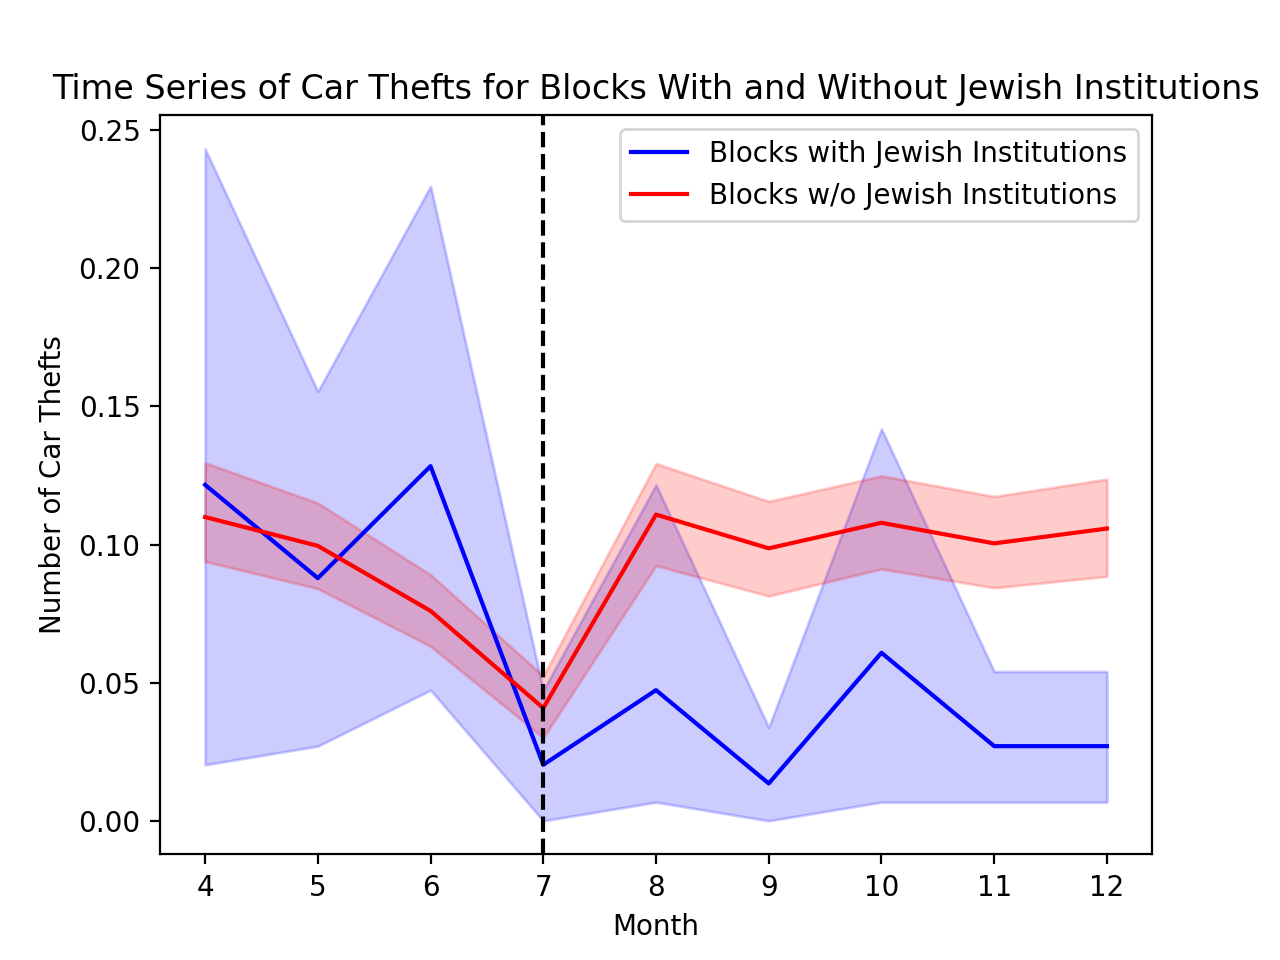

In [51]:
## Plot the time series of car thefts separately for blocks with and without a jewish institutions
## Add a vertical line indicating the terrorist attack 
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the dataframes based on jewish institutions
blocks_wo_jewish = df[df["institu1"] == 0]
blocks_with_jewish = df[df["institu1"] == 1]

# Plot the timeseries for blocks with and w/o jewish institutions
sns.lineplot(x='mes', y='totrob', data=blocks_with_jewish, label='Blocks with Jewish Institutions', color='blue')
sns.lineplot(x='mes', y='totrob', data=blocks_wo_jewish, label='Blocks w/o Jewish Institutions', color='red')

# Plot the terrorist attack
plt.axvline(x=7, color='black', linestyle='--', label='Terrorist Attack Date')

# Adding legend, title, and labels
plt.title('Time Series of Car Thefts for Blocks With and Without Jewish Institutions')
plt.xlabel('Month')
plt.ylabel('Number of Car Thefts')

plt.show()

**Does the parallel trend assumption hold?**

The parallel trend assumption holds partially since the number of car thefts is approximately the same in both kind of neighborhood.

**Run the regression above including month and block fixed effects**

In [52]:
#!pip install linearmodels
from linearmodels import PanelOLS

In [53]:
# Read again the data
df = pd.read_stata('data/HW04_data_DiD.dta')

df = df.set_index(["observ", "mes"])
df.head()

C:\Users\ronan\AppData\Local\Temp\ipykernel_10640\2963044044.py:2: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.


,,barrio,calle,altura,institu1,institu3,distanci,edpub,estserv,banco,totrob,inst3_1,month5,post,inst1p,inst3_1p
observ,mes,,,,,,,,,,,,,,,
870.0,4.0,Once,Cordoba,a2300,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
851.0,4.0,Once,Tucuman,a2400,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
843.0,4.0,Once,Lavalle,a2300,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
796.0,4.0,Once,Pasteur,a500,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
790.0,4.0,Once,Azcuenaga,a700,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
did = PanelOLS(df.totrob, df.inst1p, entity_effects=True, time_effects=True).fit()

In [55]:
##show the results from both regressions
print(did)

                          PanelOLS Estimation Summary                           
Dep. Variable:                 totrob   R-squared:                        0.0013
Estimator:                   PanelOLS   R-squared (Between):             -0.0149
No. Observations:                7884   R-squared (Within):               0.0005
Date:                Mon, Oct 23 2023   R-squared (Overall):             -0.0040
Time:                        22:28:57   Log-likelihood                    870.52
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      8.9506
Entities:                         876   P-value                           0.0028
Avg Obs:                       9.0000   Distribution:                  F(1,6999)
Min Obs:                       9.0000                                           
Max Obs:                       9.0000   F-statistic (robust):             8.9506
                            

**Compare and interpret the results**

The coeff is negative and the confidence interval is negative. So we can conclude that the presence of jewish institution is inversly correlated with the number of robberies.

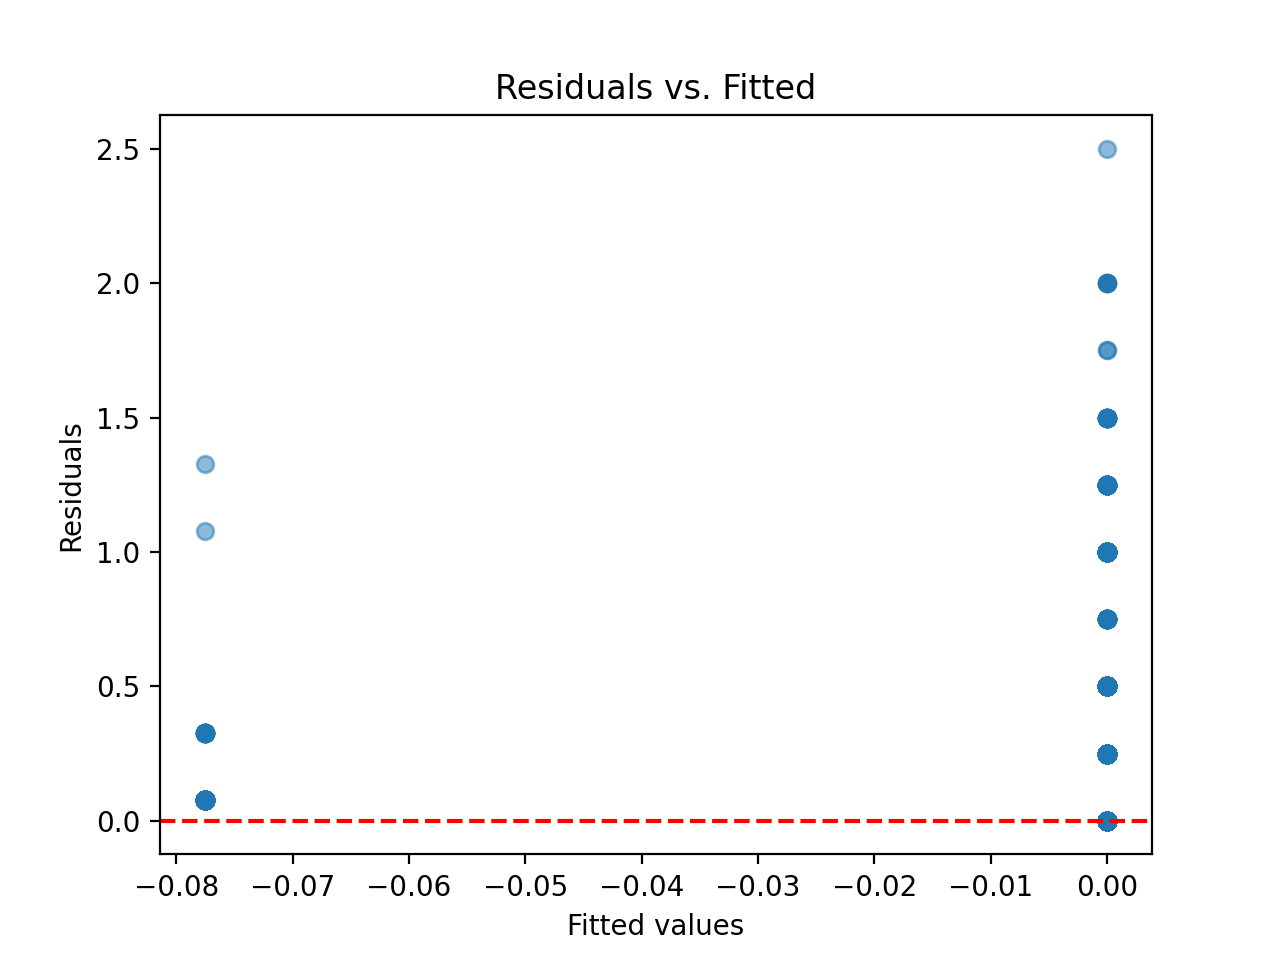

In [56]:
predicted_values = did.predict().fitted_values
residuals = df.totrob - predicted_values

plt.scatter(predicted_values, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs. Fitted')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()